# Property appraisal ML project.
## Phase 0: researching and developing baseline simple ML algorithm to predict the prices of houses

### 1. Importing the model data: the first sheet of the Reference 3 F20 P1-1.xls file
### 2. Cleanup
### 3. Feature Engineering
### 4. Developoing a very simple ML model based on linear and random forest regressions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

In [2]:
# reading one file
# df = pd.read_csv('F20 P2.csv', index_col=None, header=0)

# reading part of the files from Detached June 2020-2021 folder

data_files = ['F20 P1.csv', 'F20 P2.csv', 'F30 P1.csv', 'F30 P2.csv', 'F50 P1.csv', 'F50 P2.csv']
data_list = []

for filename in data_files:
    df_current = pd.read_csv(filename, index_col=None, header=0)
    data_list.append(df_current)

df = pd.concat(data_list, axis=0, ignore_index=True)

# deleting yellow columns
df.drop(['Status', 'For Tax Year', 'Gross Taxes', 'Original Price', 'List Price', 'GST Incl'], axis = 1, inplace = True)

# size of our dataset
print('Our dataset has', len(df), 'data lines and', len(df.columns.tolist()), 'features:')
print('\n')
print(df.columns.tolist())

Our dataset has 5844 data lines and 23 features:


['Address', 'S/A', 'Price', 'Sold Date', 'Days On Market', 'Age', 'Area', 'Total Bedrooms', 'Total Baths', 'Lot Sz (Sq.Ft.)', 'Floor Area -Grand Total', 'Driveway Finish', 'Floor Area - Unfinished', 'Foundation', 'Floor Area Fin - Basement', 'Zoning', 'Parking Places - Covered', '# Rms', 'No. Floor Levels', 'Frontage - Feet', 'Depth', 'Type', 'Public Remarks']


In [3]:
# dropping the columns with more than 90% NAs
moreThan = []

for feature in df:
    if df[feature].isna().sum() / df.shape[0] > 0.9:
        moreThan.append(feature)
        print("Dropping the feature:", feature)
df.drop(moreThan, axis = 1, inplace = True)

if moreThan == []:
    print('No features dropped.')
print('\n')

# dropping the columns that are not insightful: Days On Market, Public Remarks
# df1.drop(['Sold Date', 'Public Remarks'], axis=1, inplace = True)
# df.drop(['Public Remarks'], axis=1, inplace = True)

columns_names = df.columns.tolist()

print("Features left:")
print(columns_names)
print('\n')
print("Now we have", len(columns_names), "features and their types:")

# types of our columns
pd.DataFrame(df.dtypes, columns=['DataTypes'])

No features dropped.


Features left:
['Address', 'S/A', 'Price', 'Sold Date', 'Days On Market', 'Age', 'Area', 'Total Bedrooms', 'Total Baths', 'Lot Sz (Sq.Ft.)', 'Floor Area -Grand Total', 'Driveway Finish', 'Floor Area - Unfinished', 'Foundation', 'Floor Area Fin - Basement', 'Zoning', 'Parking Places - Covered', '# Rms', 'No. Floor Levels', 'Frontage - Feet', 'Depth', 'Type', 'Public Remarks']


Now we have 23 features and their types:


,DataTypes
Address,object
S/A,object
Price,object
Sold Date,object
Days On Market,int64
Age,float64
Area,object
Total Bedrooms,int64
Total Baths,int64
Lot Sz (Sq.Ft.),object


In [4]:
df1 = df.copy()

df1.drop(['Public Remarks'], axis=1, inplace = True)
df1.drop(['Address'], axis=1, inplace = True)

df1['Price'] = df1['Price'].str.replace('$','').str.replace(',','').astype(int)

df1['Sold Date'] = df1['Sold Date'].str.split("/")
df1['Sold Year'] = df1['Sold Date'].str[2]
df1['Sold Month'] = df1['Sold Date'].str[0]
df1.drop(['Sold Date'], axis=1, inplace = True)

df1['Age'] = df1['Age'].fillna(-1).astype(int)
df1.loc[df1['Age'] > 150, 'Age'] = 150

df1['Lot Sz (Sq.Ft.)'] = df1['Lot Sz (Sq.Ft.)'].str.replace(',', '').astype(float)
# df1.drop(df1[df1['Lot Sz (Sq.Ft.)'] > 50000].index, inplace = True)
# df1.drop(df1[df1['Lot Sz (Sq.Ft.)'] < 100].index, inplace = True)

df1['Floor Area -Grand Total'] = df1['Floor Area -Grand Total'].str.replace(',', '').astype(int)

# df1['Driveway Finish'] = df1['Driveway Finish'].astype(str)

df1['Floor Area - Unfinished'] = df1['Floor Area - Unfinished'].str.replace(',', '').astype(int)

df1['Foundation'] = df1['Foundation'].astype(str)

df1['Floor Area Fin - Basement'] = df1['Floor Area Fin - Basement'].str.replace(',', '').astype(float)

df1['Zoning'] = df1['Zoning'].astype(str)
df1['Zoning'] = df1['Zoning'].str.replace('A1', 'A-1')
df1['Zoning'] = df1['Zoning'].str.replace('A2', 'A-2')
df1['Zoning'] = df1['Zoning'].str.replace('1ACRER', 'RA')
df1['Zoning'] = df1['Zoning'].str.replace('1 AR', 'RA')
df1['Zoning'] = df1['Zoning'].str.replace('RF13', 'RF-13')
df1['Zoning'] = df1['Zoning'].str.replace('RHG', 'RH-G')
df1['Zoning'] = df1['Zoning'].str.replace('RS-1', 'RS1')
df1['Zoning'] = df1['Zoning'].str.replace('SING/F', 'SING')

df1['Parking Places - Covered'] = df1['Parking Places - Covered'].fillna(-1) ### or -1

df1.loc[df1['No. Floor Levels'] > 10, 'No. Floor Levels'] = -1

df1['Frontage - Feet'] = df1['Frontage - Feet'].str.replace(',', '').astype(float)
df1['Frontage - Feet'] = df1['Frontage - Feet'].fillna(-1) ### or -1

df1 = df1.drop(['Depth'], axis=1)

df1['new feature 1'] = (df1['Total Bedrooms'] + df1['# Rms'])

df1['Total Baths'] = df1['Total Baths'].astype(str)
df1['# Rms'] = df1['# Rms'].astype(str)

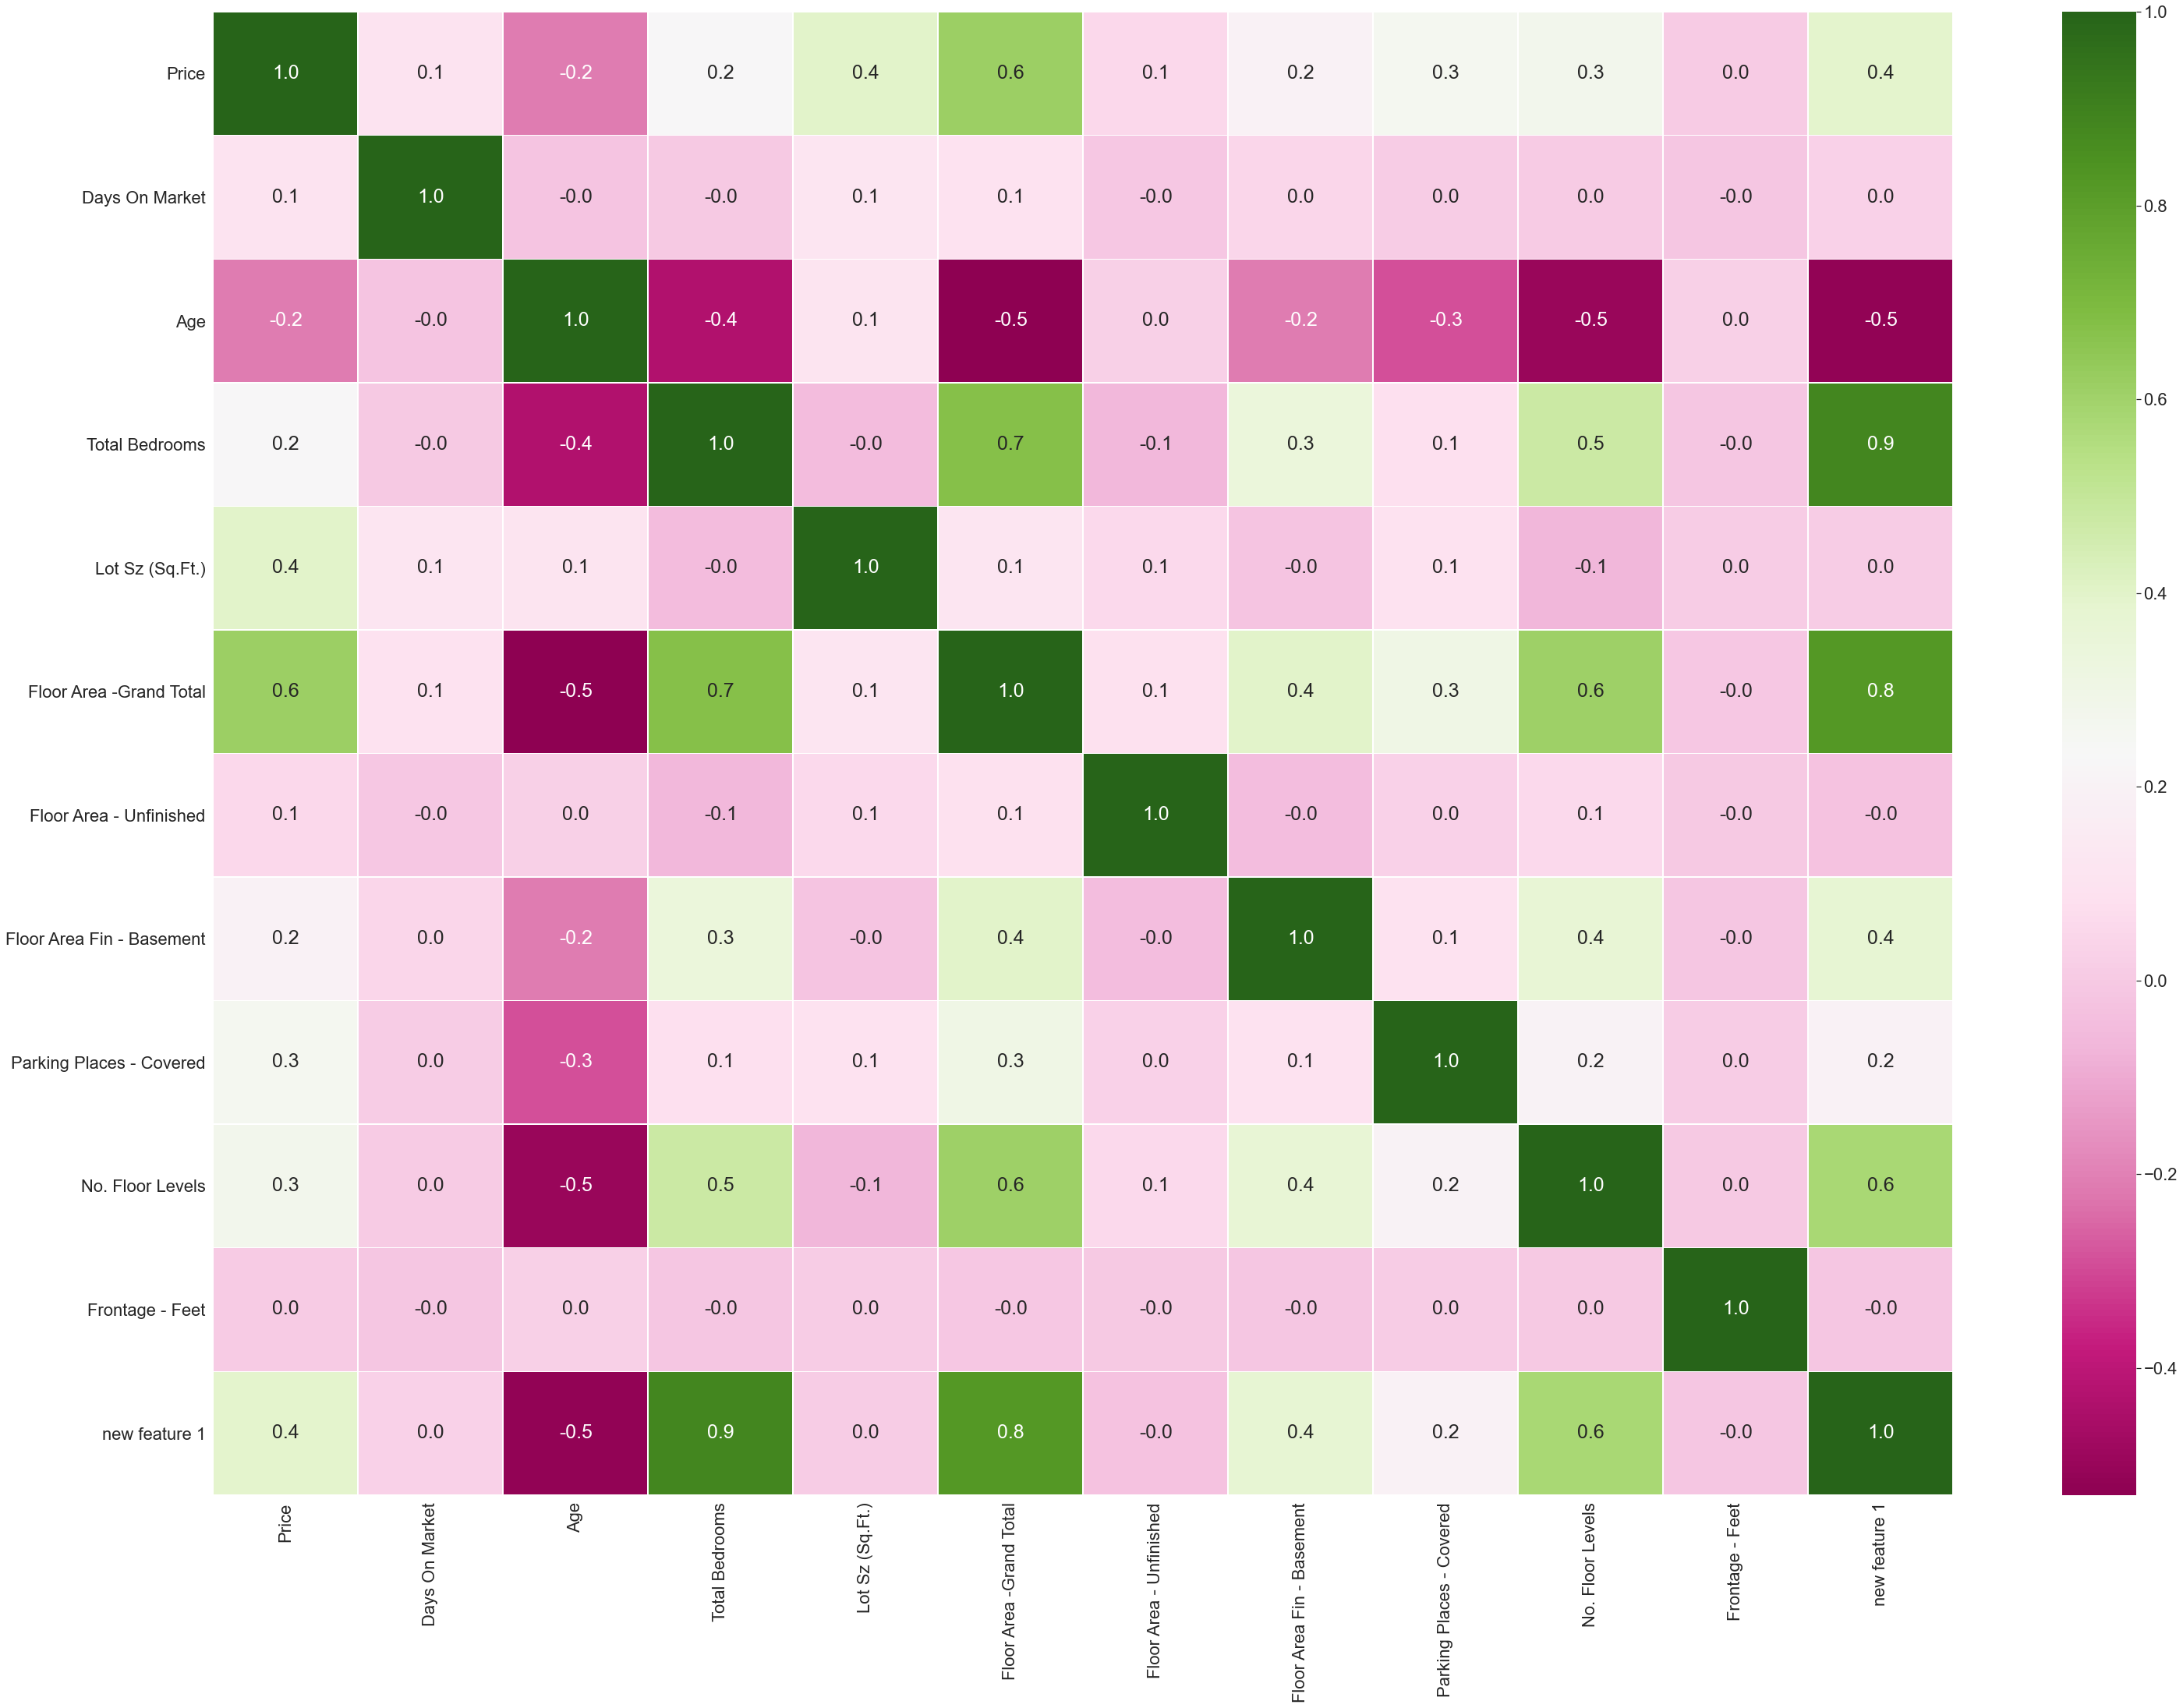

In [5]:
# calculating correlations between features to see what are the most interesting ones
correlation_df1 = df1.corr()
sb.set(font_scale=2)
plt.figure(figsize = (50,35))
ax = sb.heatmap(correlation_df1, annot=True,annot_kws={"size": 25},fmt='.1f',cmap='PiYG', linewidths=.5)

In [6]:
# the price feature
y = df1['Price']

# one-hot-encoding categorical features
X1 = pd.get_dummies(df1[[ 'Total Baths', '# Rms',  'S/A',  'Area', 'Driveway Finish', 'Foundation', 'Type', 'Zoning', 'Sold Year', 'Sold Month']])

X2 = df1.drop(['Total Baths', '# Rms', 'S/A', 'Area', 'Driveway Finish', 'Foundation', 'Type', 'Zoning', 'Sold Year', 'Sold Month', 'Price'], axis = 1)
X2.fillna(-1)

# generating a big preprocessed dataset
X = pd.concat([X1, X2], axis = 1)

# finally, we have 362 features
X.shape

(5844, 362)

/Users/tigrani/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

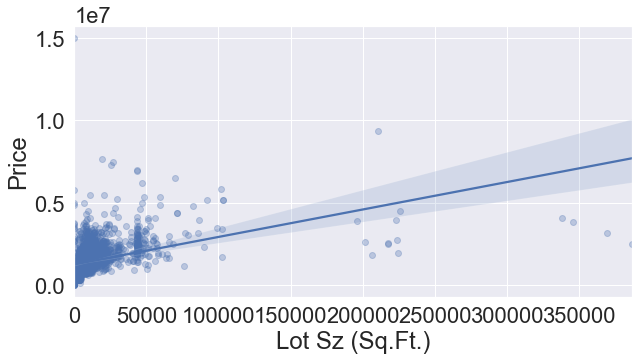

In [7]:
# just plotting one of the variables vs price: this step I used to get an idea on what ensembling algorithm will be good
# some insgiths will be at the end of this notebook
plt.figure(figsize=(10,5))
sb.regplot(df1['Lot Sz (Sq.Ft.)'], y, scatter_kws={'alpha':0.3})
plt.show

# Metrics

1. results_score showing what % of values are predicted for <= 2, 3, 5, 10, 20 % of accuracy
2. Mean absolute percentage error
3. Median absolute percentage error

In [8]:
# These functions take as inputs the real and predicted values 

# 1. % of values are predicted for <= 2, 3, 5, 10, 20 % of accuracy
def results_score(real_values, predictions):
    percentage_list = [2, 3, 5, 10, 20]
    
    for percentage in percentage_list:
        diff_list = []
        diff_list = np.abs((np.array(real_values) - np.round(predictions,1)))/np.array(real_values) * 100
        print(np.round(np.shape(np.where(np.round(diff_list,2) <= percentage))[1] / np.shape(real_values)[0] * 100, 1), '% of predited values has <=', percentage, '% accuracy.')
        
# 2. Mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 3. Median absolute percentage error
def median_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

# Simple ML algorithm aka baseline solution

In [9]:
# now we make an ensemble learning using RandomForest, DecisionTree and XBG regressors and Ridge regression below that
# one might use more regressors but this will not significantly improve the results. even it might generate worst results

from sklearn.linear_model import Ridge, LassoCV
import xgboost as xgb
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 42)
regr = 0

### Model
estimators = [
#     ('lr1', LassoCV()),
    ('lr2', RandomForestRegressor(n_estimators=7, random_state = 42, n_jobs=-1)),
    ('lr3', xgb.XGBRegressor(n_estimators=73, learning_rate=0.1, gamma=0, subsample=0.75, colsample_bytree=1)),
    ('lr4', DecisionTreeRegressor(random_state=0))
    ]
regr = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge()
)

regr.fit(X_train, y_train)
print('model fitted')

y_test_pred = np.round(regr.predict(X_test))
y_train_pred = np.round(regr.predict(X_train))

/Users/tigrani/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


model fitted


/Users/tigrani/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/tigrani/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [10]:
# now metrics:

print('Results for test dataset:')
results_score(y_test, y_test_pred)

print('\n')
print('Results for train dataset (to check if we have overfitting or the results are comparable with those on test dataset):')
results_score(y_train, y_train_pred)

Results for test dataset:
19.4 % of predited values has <= 2 % accuracy.
27.2 % of predited values has <= 3 % accuracy.
43.5 % of predited values has <= 5 % accuracy.
70.2 % of predited values has <= 10 % accuracy.
90.8 % of predited values has <= 20 % accuracy.


Results for train dataset (to check if we have overfitting or the results are comparable with those on test dataset):
28.1 % of predited values has <= 2 % accuracy.
41.1 % of predited values has <= 3 % accuracy.
61.5 % of predited values has <= 5 % accuracy.
86.9 % of predited values has <= 10 % accuracy.
97.6 % of predited values has <= 20 % accuracy.


In [11]:
# Mean absolute percentage error

print('Mean absolute percentage error, results on test dataset:')
print(mean_absolute_percentage_error(y_test, y_test_pred))

print('\n')
print('Mean absolute percentage error, results on train dataset:')
mean_absolute_percentage_error(y_train, y_train_pred)

Mean absolute percentage error, results on test dataset:
8.930510794967105


Mean absolute percentage error, results on train dataset:


5.59448750409898

In [12]:
# Median absolute percentage error

print('Median absolute percentage error, results on test dataset:')
print(median_absolute_percentage_error(y_test, y_test_pred))

print('\n')
print('Median absolute percentage error, results on train dataset:')
median_absolute_percentage_error(y_train, y_train_pred)

Median absolute percentage error, results on test dataset:
5.878399378399378


Median absolute percentage error, results on train dataset:


3.706933115823817

# Insights

We see that these algorithms are far away from the final needed accuracies. This is due to the data is rather scattered and although I've used advanced techincs for cleaning and preprocessing the dataset (like encoding all the integer features into different feature columns - one-hot-encode number of rooms feature, etc.) - it is not suitable for one step machine learning as as an example houses with similar area might have very different prices based on other features. 
So, think there is no room for significant improvement using this one-step ML method. An algorithm based on similarity ranking {hopefully} will fix the situation.

### Update from Feb 22, 2022
Median absolute percentage error {that is used in Zillow} here shows ~6% deviation on train and ~9% deviation on test datasets <b>for this simple baseline solution</b>. Recall that in Zillow it gives ~2%!

